# Medical Image Classification with MONAI

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

In [6]:
class _3D_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        return {'images': data, 'label': label}

In [7]:
train_dataset_ = _3D_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = _3D_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = _3D_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Training cycle

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=3, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [9]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.16it/s, train_loss=1.85]
                                                                                  

epoch 1 average loss: 1.6798
1


Epochs:   1%|          | 1/100 [00:34<56:19, 34.14s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5794 current accuracy: 0.1118 best AUC: 0.5794 at epoch: 1
----------
epoch 2/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.07it/s, train_loss=0.535]
                                                                                   

epoch 2 average loss: 0.8960
1


Epochs:   2%|▏         | 2/100 [01:10<57:45, 35.36s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9498 current accuracy: 0.5590 best AUC: 0.9498 at epoch: 2
----------
epoch 3/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.05it/s, train_loss=0.938]
                                                                                   

epoch 3 average loss: 0.7023
1


Epochs:   3%|▎         | 3/100 [01:46<58:04, 35.92s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9904 current accuracy: 0.6957 best AUC: 0.9904 at epoch: 3
----------
epoch 4/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.11it/s, train_loss=0.644]
                                                                                   

epoch 4 average loss: 0.6386


Epochs:   4%|▍         | 4/100 [02:21<56:41, 35.43s/it]

1
current epoch: 4 current AUC: 0.9694 current accuracy: 0.6335 best AUC: 0.9904 at epoch: 3
----------
epoch 5/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.35it/s, train_loss=1.09]
                                                                                  

epoch 5 average loss: 0.6060
1


Epochs:   5%|▌         | 5/100 [02:53<54:19, 34.32s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9954 current accuracy: 0.8075 best AUC: 0.9954 at epoch: 5
----------
epoch 6/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.17it/s, train_loss=0.552]
                                                                                   

epoch 6 average loss: 0.5079


Epochs:   6%|▌         | 6/100 [03:26<53:02, 33.85s/it]

1
current epoch: 6 current AUC: 0.9858 current accuracy: 0.7143 best AUC: 0.9954 at epoch: 5
----------
epoch 7/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.10it/s, train_loss=0.675]
                                                                                   

epoch 7 average loss: 0.4636


Epochs:   7%|▋         | 7/100 [04:00<52:09, 33.65s/it]

1
current epoch: 7 current AUC: 0.9855 current accuracy: 0.7764 best AUC: 0.9954 at epoch: 5
----------
epoch 8/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.08it/s, train_loss=0.535]
                                                                                   

epoch 8 average loss: 0.3947


Epochs:   8%|▊         | 8/100 [04:32<50:51, 33.17s/it]

1
current epoch: 8 current AUC: 0.9922 current accuracy: 0.7888 best AUC: 0.9954 at epoch: 5
----------
epoch 9/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.03it/s, train_loss=0.519]
                                                                                   

epoch 9 average loss: 0.4157


Epochs:   9%|▉         | 9/100 [05:06<51:01, 33.65s/it]

1
current epoch: 9 current AUC: 0.9875 current accuracy: 0.6149 best AUC: 0.9954 at epoch: 5
----------
epoch 10/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.28it/s, train_loss=0.33]
                                                                                  

epoch 10 average loss: 0.3817


Epochs:  10%|█         | 10/100 [05:39<49:48, 33.21s/it]

1
current epoch: 10 current AUC: 0.9937 current accuracy: 0.9068 best AUC: 0.9954 at epoch: 5
----------
epoch 11/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.09it/s, train_loss=0.217]
                                                                                   

epoch 11 average loss: 0.3499


Epochs:  11%|█         | 11/100 [06:12<49:31, 33.38s/it]

1
current epoch: 11 current AUC: 0.9937 current accuracy: 0.8385 best AUC: 0.9954 at epoch: 5
----------
epoch 12/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.18it/s, train_loss=0.365]
                                                                                   

epoch 12 average loss: 0.3149


Epochs:  12%|█▏        | 12/100 [06:45<48:42, 33.22s/it]

1
current epoch: 12 current AUC: 0.9930 current accuracy: 0.8634 best AUC: 0.9954 at epoch: 5
----------
epoch 13/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.09it/s, train_loss=0.153]
                                                                                   

epoch 13 average loss: 0.2785


Epochs:  13%|█▎        | 13/100 [07:20<48:46, 33.64s/it]

1
current epoch: 13 current AUC: 0.9946 current accuracy: 0.8758 best AUC: 0.9954 at epoch: 5
----------
epoch 14/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.00s/it, train_loss=0.734]
                                                                                   

epoch 14 average loss: 0.2837


Epochs:  14%|█▍        | 14/100 [07:54<48:35, 33.90s/it]

1
current epoch: 14 current AUC: 0.9942 current accuracy: 0.8261 best AUC: 0.9954 at epoch: 5
----------
epoch 15/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.20it/s, train_loss=0.399]
                                                                                   

epoch 15 average loss: 0.2783


Epochs:  15%|█▌        | 15/100 [08:28<47:55, 33.83s/it]

1
current epoch: 15 current AUC: 0.9911 current accuracy: 0.8137 best AUC: 0.9954 at epoch: 5
----------
epoch 16/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.17it/s, train_loss=0.202]
                                                                                   

epoch 16 average loss: 0.3018


Epochs:  16%|█▌        | 16/100 [08:59<46:15, 33.04s/it]

1
current epoch: 16 current AUC: 0.9947 current accuracy: 0.8509 best AUC: 0.9954 at epoch: 5
----------
epoch 17/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s, train_loss=0.539]
                                                                                   

epoch 17 average loss: 0.2358


Epochs:  17%|█▋        | 17/100 [09:30<44:54, 32.47s/it]

1
current epoch: 17 current AUC: 0.9909 current accuracy: 0.8323 best AUC: 0.9954 at epoch: 5
----------
epoch 18/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.17it/s, train_loss=0.341]
                                                                                   

epoch 18 average loss: 0.2314


Epochs:  18%|█▊        | 18/100 [10:03<44:31, 32.58s/it]

1
current epoch: 18 current AUC: 0.9895 current accuracy: 0.7950 best AUC: 0.9954 at epoch: 5
----------
epoch 19/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.17it/s, train_loss=0.135]
                                                                                   

epoch 19 average loss: 0.2520
1


Epochs:  19%|█▉        | 19/100 [10:40<45:27, 33.68s/it]

saved new best metric model
current epoch: 19 current AUC: 0.9980 current accuracy: 0.8447 best AUC: 0.9980 at epoch: 19
----------
epoch 20/100



Training Batches: 100%|██████████| 31/31 [00:35<00:00,  1.21it/s, train_loss=0.507]
                                                                                   

epoch 20 average loss: 0.2325


Epochs:  20%|██        | 20/100 [11:15<45:46, 34.33s/it]

1
current epoch: 20 current AUC: 0.9971 current accuracy: 0.8634 best AUC: 0.9980 at epoch: 19
----------
epoch 21/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.16it/s, train_loss=0.258]
                                                                                   

epoch 21 average loss: 0.2309


Epochs:  21%|██        | 21/100 [11:48<44:29, 33.79s/it]

1
current epoch: 21 current AUC: 0.9973 current accuracy: 0.8571 best AUC: 0.9980 at epoch: 19
----------
epoch 22/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.26it/s, train_loss=0.181]
                                                                                   

epoch 22 average loss: 0.2085


Epochs:  22%|██▏       | 22/100 [12:20<43:23, 33.37s/it]

1
current epoch: 22 current AUC: 0.9840 current accuracy: 0.7764 best AUC: 0.9980 at epoch: 19
----------
epoch 23/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.35it/s, train_loss=0.175]
                                                                                   

epoch 23 average loss: 0.1636


Epochs:  23%|██▎       | 23/100 [12:52<42:00, 32.73s/it]

1
current epoch: 23 current AUC: 0.9937 current accuracy: 0.8820 best AUC: 0.9980 at epoch: 19
----------
epoch 24/100



Training Batches: 100%|██████████| 31/31 [00:29<00:00,  1.20it/s, train_loss=0.315]
                                                                                   

epoch 24 average loss: 0.1797


Epochs:  24%|██▍       | 24/100 [13:22<40:41, 32.13s/it]

1
current epoch: 24 current AUC: 0.9955 current accuracy: 0.9193 best AUC: 0.9980 at epoch: 19
----------
epoch 25/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.29it/s, train_loss=0.217]
                                                                                   

epoch 25 average loss: 0.1565


Epochs:  25%|██▌       | 25/100 [13:53<39:46, 31.81s/it]

1
current epoch: 25 current AUC: 0.9955 current accuracy: 0.8944 best AUC: 0.9980 at epoch: 19
----------
epoch 26/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.09it/s, train_loss=0.557]
                                                                                   

epoch 26 average loss: 0.1580


Epochs:  26%|██▌       | 26/100 [14:25<39:18, 31.87s/it]

1
current epoch: 26 current AUC: 0.9907 current accuracy: 0.8882 best AUC: 0.9980 at epoch: 19
----------
epoch 27/100



Training Batches: 100%|██████████| 31/31 [00:28<00:00,  1.44it/s, train_loss=0.38]
                                                                                  

epoch 27 average loss: 0.1815


Epochs:  27%|██▋       | 27/100 [14:55<37:54, 31.16s/it]

1
current epoch: 27 current AUC: 0.9947 current accuracy: 0.8385 best AUC: 0.9980 at epoch: 19
----------
epoch 28/100



Training Batches: 100%|██████████| 31/31 [00:28<00:00,  1.18it/s, train_loss=0.163]
                                                                                   

epoch 28 average loss: 0.1525


Epochs:  28%|██▊       | 28/100 [15:24<36:36, 30.51s/it]

1
current epoch: 28 current AUC: 0.9963 current accuracy: 0.8634 best AUC: 0.9980 at epoch: 19
----------
epoch 29/100



Training Batches: 100%|██████████| 31/31 [00:29<00:00,  1.29it/s, train_loss=0.185]
                                                                                   

epoch 29 average loss: 0.1356


Epochs:  29%|██▉       | 29/100 [15:54<36:01, 30.44s/it]

1
current epoch: 29 current AUC: 0.9881 current accuracy: 0.8696 best AUC: 0.9980 at epoch: 19
----------
epoch 30/100



Training Batches: 100%|██████████| 31/31 [00:29<00:00,  1.18it/s, train_loss=0.0361]
                                                                                    

epoch 30 average loss: 0.1137


Epochs:  30%|███       | 30/100 [16:25<35:30, 30.44s/it]

1
current epoch: 30 current AUC: 0.9926 current accuracy: 0.9006 best AUC: 0.9980 at epoch: 19
----------
epoch 31/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.17it/s, train_loss=0.0815]
                                                                                    

epoch 31 average loss: 0.1019


Epochs:  31%|███       | 31/100 [16:57<35:43, 31.07s/it]

1
current epoch: 31 current AUC: 0.9894 current accuracy: 0.8696 best AUC: 0.9980 at epoch: 19
----------
epoch 32/100



Training Batches: 100%|██████████| 31/31 [00:29<00:00,  1.32it/s, train_loss=0.0458]
                                                                                    

epoch 32 average loss: 0.0947


Epochs:  32%|███▏      | 32/100 [17:27<34:56, 30.84s/it]

1
current epoch: 32 current AUC: 0.9943 current accuracy: 0.9379 best AUC: 0.9980 at epoch: 19
----------
epoch 33/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.30it/s, train_loss=0.0728]
                                                                                    

epoch 33 average loss: 0.0790


Epochs:  33%|███▎      | 33/100 [17:58<34:25, 30.83s/it]

1
current epoch: 33 current AUC: 0.9899 current accuracy: 0.8820 best AUC: 0.9980 at epoch: 19
----------
epoch 34/100



Training Batches: 100%|██████████| 31/31 [00:29<00:00,  1.26it/s, train_loss=0.0655]
                                                                                    

epoch 34 average loss: 0.0993


Epochs:  34%|███▍      | 34/100 [18:28<33:38, 30.59s/it]

1
current epoch: 34 current AUC: 0.9978 current accuracy: 0.9441 best AUC: 0.9980 at epoch: 19
----------
epoch 35/100



Training Batches: 100%|██████████| 31/31 [00:28<00:00,  1.39it/s, train_loss=0.116]
                                                                                   

epoch 35 average loss: 0.0988


Epochs:  35%|███▌      | 35/100 [18:57<32:36, 30.10s/it]

1
current epoch: 35 current AUC: 0.9906 current accuracy: 0.8882 best AUC: 0.9980 at epoch: 19
----------
epoch 36/100



Training Batches: 100%|██████████| 31/31 [00:28<00:00,  1.34it/s, train_loss=0.133]
                                                                                   

epoch 36 average loss: 0.0795


Epochs:  36%|███▌      | 36/100 [19:27<31:54, 29.91s/it]

1
current epoch: 36 current AUC: 0.9728 current accuracy: 0.7640 best AUC: 0.9980 at epoch: 19
----------
epoch 37/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.26it/s, train_loss=0.179]
                                                                                   

epoch 37 average loss: 0.0901


Epochs:  37%|███▋      | 37/100 [19:58<31:47, 30.28s/it]

1
current epoch: 37 current AUC: 0.9912 current accuracy: 0.8634 best AUC: 0.9980 at epoch: 19
----------
epoch 38/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.05it/s, train_loss=0.218]
                                                                                   

epoch 38 average loss: 0.0758


Epochs:  38%|███▊      | 38/100 [20:30<31:53, 30.86s/it]

1
current epoch: 38 current AUC: 0.9904 current accuracy: 0.8882 best AUC: 0.9980 at epoch: 19
----------
epoch 39/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.08it/s, train_loss=0.0364]
                                                                                    

epoch 39 average loss: 0.0914


Epochs:  39%|███▉      | 39/100 [21:03<31:54, 31.39s/it]

1
current epoch: 39 current AUC: 0.9850 current accuracy: 0.6832 best AUC: 0.9980 at epoch: 19
----------
epoch 40/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.03it/s, train_loss=0.207]
                                                                                   

epoch 40 average loss: 0.0822


Epochs:  40%|████      | 40/100 [21:36<31:53, 31.90s/it]

1
current epoch: 40 current AUC: 0.9884 current accuracy: 0.8323 best AUC: 0.9980 at epoch: 19
----------
epoch 41/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.28it/s, train_loss=0.0338]
                                                                                    

epoch 41 average loss: 0.0848


Epochs:  41%|████      | 41/100 [22:09<31:45, 32.29s/it]

1
current epoch: 41 current AUC: 0.9864 current accuracy: 0.8571 best AUC: 0.9980 at epoch: 19
----------
epoch 42/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.22it/s, train_loss=0.126]
                                                                                   

epoch 42 average loss: 0.0734


Epochs:  42%|████▏     | 42/100 [22:44<31:54, 33.00s/it]

1
current epoch: 42 current AUC: 0.9935 current accuracy: 0.8820 best AUC: 0.9980 at epoch: 19
----------
epoch 43/100



Training Batches: 100%|██████████| 31/31 [00:35<00:00,  1.06it/s, train_loss=0.0238]
                                                                                    

epoch 43 average loss: 0.0595


Epochs:  43%|████▎     | 43/100 [23:20<32:13, 33.92s/it]

1
current epoch: 43 current AUC: 0.9888 current accuracy: 0.8447 best AUC: 0.9980 at epoch: 19
----------
epoch 44/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.19it/s, train_loss=0.0526]
                                                                                    

epoch 44 average loss: 0.0736


Epochs:  44%|████▍     | 44/100 [23:54<31:40, 33.94s/it]

1
current epoch: 44 current AUC: 0.9973 current accuracy: 0.9130 best AUC: 0.9980 at epoch: 19
----------
epoch 45/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.11it/s, train_loss=0.0155]
                                                                                    

epoch 45 average loss: 0.0753


Epochs:  45%|████▌     | 45/100 [24:27<31:03, 33.88s/it]

1
current epoch: 45 current AUC: 0.9897 current accuracy: 0.8882 best AUC: 0.9980 at epoch: 19
----------
epoch 46/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.21it/s, train_loss=0.0206]
                                                                                    

epoch 46 average loss: 0.0648


Epochs:  46%|████▌     | 46/100 [24:59<29:51, 33.18s/it]

1
current epoch: 46 current AUC: 0.9926 current accuracy: 0.8882 best AUC: 0.9980 at epoch: 19
----------
epoch 47/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.13it/s, train_loss=0.288]
                                                                                   

epoch 47 average loss: 0.0663


Epochs:  47%|████▋     | 47/100 [25:32<29:24, 33.30s/it]

1
current epoch: 47 current AUC: 0.9905 current accuracy: 0.8944 best AUC: 0.9980 at epoch: 19
----------
epoch 48/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.14it/s, train_loss=0.186]
                                                                                   

epoch 48 average loss: 0.0786


Epochs:  48%|████▊     | 48/100 [26:05<28:37, 33.03s/it]

1
current epoch: 48 current AUC: 0.9960 current accuracy: 0.9255 best AUC: 0.9980 at epoch: 19
----------
epoch 49/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.21it/s, train_loss=0.153]
                                                                                   

epoch 49 average loss: 0.0728


Epochs:  49%|████▉     | 49/100 [26:40<28:31, 33.57s/it]

1
current epoch: 49 current AUC: 0.9959 current accuracy: 0.9255 best AUC: 0.9980 at epoch: 19
----------
epoch 50/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.09it/s, train_loss=0.125]
                                                                                   

epoch 50 average loss: 0.0550


Epochs:  50%|█████     | 50/100 [27:13<27:57, 33.55s/it]

1
current epoch: 50 current AUC: 0.9957 current accuracy: 0.9565 best AUC: 0.9980 at epoch: 19
----------
epoch 51/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.22it/s, train_loss=0.017]
                                                                                   

epoch 51 average loss: 0.0587


Epochs:  51%|█████     | 51/100 [27:48<27:41, 33.90s/it]

1
current epoch: 51 current AUC: 0.9919 current accuracy: 0.9006 best AUC: 0.9980 at epoch: 19
----------
epoch 52/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.06it/s, train_loss=0.0214]
                                                                                    

epoch 52 average loss: 0.0531


Epochs:  52%|█████▏    | 52/100 [28:20<26:46, 33.46s/it]

1
current epoch: 52 current AUC: 0.9947 current accuracy: 0.9441 best AUC: 0.9980 at epoch: 19
----------
epoch 53/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.30it/s, train_loss=0.0297]
                                                                                    

epoch 53 average loss: 0.0455


Epochs:  53%|█████▎    | 53/100 [28:54<26:10, 33.41s/it]

1
current epoch: 53 current AUC: 0.9979 current accuracy: 0.9130 best AUC: 0.9980 at epoch: 19
----------
epoch 54/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.25it/s, train_loss=0.132]
                                                                                   

epoch 54 average loss: 0.0631


Epochs:  54%|█████▍    | 54/100 [29:25<25:02, 32.67s/it]

1
current epoch: 54 current AUC: 0.9968 current accuracy: 0.8944 best AUC: 0.9980 at epoch: 19
----------
epoch 55/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.23it/s, train_loss=0.0123]
                                                                                    

epoch 55 average loss: 0.0385


Epochs:  55%|█████▌    | 55/100 [29:57<24:32, 32.71s/it]

1
current epoch: 55 current AUC: 0.9950 current accuracy: 0.9379 best AUC: 0.9980 at epoch: 19
----------
epoch 56/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.08it/s, train_loss=0.048]
                                                                                   

epoch 56 average loss: 0.0362


Epochs:  56%|█████▌    | 56/100 [30:32<24:19, 33.17s/it]

1
current epoch: 56 current AUC: 0.9947 current accuracy: 0.9255 best AUC: 0.9980 at epoch: 19
----------
epoch 57/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.16it/s, train_loss=0.0146]
                                                                                    

epoch 57 average loss: 0.0322


Epochs:  57%|█████▋    | 57/100 [31:05<23:53, 33.33s/it]

1
current epoch: 57 current AUC: 0.9902 current accuracy: 0.9130 best AUC: 0.9980 at epoch: 19
----------
epoch 58/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.03it/s, train_loss=0.0215]
                                                                                    

epoch 58 average loss: 0.0642


Epochs:  58%|█████▊    | 58/100 [31:41<23:47, 34.00s/it]

1
current epoch: 58 current AUC: 0.9911 current accuracy: 0.8820 best AUC: 0.9980 at epoch: 19
----------
epoch 59/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.22it/s, train_loss=0.015]
                                                                                   

epoch 59 average loss: 0.0525


Epochs:  59%|█████▉    | 59/100 [32:14<22:56, 33.58s/it]

1
current epoch: 59 current AUC: 0.9934 current accuracy: 0.8509 best AUC: 0.9980 at epoch: 19
----------
epoch 60/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.15it/s, train_loss=0.0644]
                                                                                    

epoch 60 average loss: 0.0356


Epochs:  60%|██████    | 60/100 [32:46<22:08, 33.21s/it]

1
current epoch: 60 current AUC: 0.9929 current accuracy: 0.9193 best AUC: 0.9980 at epoch: 19
----------
epoch 61/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.13it/s, train_loss=0.012]
                                                                                   

epoch 61 average loss: 0.0454
1


Epochs:  61%|██████    | 61/100 [33:20<21:47, 33.53s/it]

saved new best metric model
current epoch: 61 current AUC: 0.9984 current accuracy: 0.9565 best AUC: 0.9984 at epoch: 61
----------
epoch 62/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.02it/s, train_loss=0.223]
                                                                                   

epoch 62 average loss: 0.0635


Epochs:  62%|██████▏   | 62/100 [33:56<21:36, 34.13s/it]

1
current epoch: 62 current AUC: 0.9932 current accuracy: 0.9068 best AUC: 0.9984 at epoch: 61
----------
epoch 63/100



Training Batches: 100%|██████████| 31/31 [00:35<00:00,  1.00s/it, train_loss=0.00876]
                                                                                     

epoch 63 average loss: 0.0522


Epochs:  63%|██████▎   | 63/100 [34:32<21:25, 34.74s/it]

1
current epoch: 63 current AUC: 0.9955 current accuracy: 0.9317 best AUC: 0.9984 at epoch: 61
----------
epoch 64/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.12it/s, train_loss=0.187]
                                                                                   

epoch 64 average loss: 0.0512


Epochs:  64%|██████▍   | 64/100 [35:05<20:32, 34.24s/it]

1
current epoch: 64 current AUC: 0.9958 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 65/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.12it/s, train_loss=0.00436]
                                                                                     

epoch 65 average loss: 0.0428


Epochs:  65%|██████▌   | 65/100 [35:39<19:53, 34.09s/it]

1
current epoch: 65 current AUC: 0.9928 current accuracy: 0.8944 best AUC: 0.9984 at epoch: 61
----------
epoch 66/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.23it/s, train_loss=0.00786]
                                                                                     

epoch 66 average loss: 0.0549


Epochs:  66%|██████▌   | 66/100 [36:12<19:08, 33.77s/it]

1
current epoch: 66 current AUC: 0.9964 current accuracy: 0.9317 best AUC: 0.9984 at epoch: 61
----------
epoch 67/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.09it/s, train_loss=0.811]
                                                                                   

epoch 67 average loss: 0.0667


Epochs:  67%|██████▋   | 67/100 [36:47<18:44, 34.08s/it]

1
current epoch: 67 current AUC: 0.9960 current accuracy: 0.9255 best AUC: 0.9984 at epoch: 61
----------
epoch 68/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.17it/s, train_loss=0.148]
                                                                                   

epoch 68 average loss: 0.0745


Epochs:  68%|██████▊   | 68/100 [37:20<18:00, 33.76s/it]

1
current epoch: 68 current AUC: 0.9966 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 69/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.20it/s, train_loss=0.0174]
                                                                                    

epoch 69 average loss: 0.0530


Epochs:  69%|██████▉   | 69/100 [37:53<17:25, 33.73s/it]

1
current epoch: 69 current AUC: 0.9944 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 70/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.12it/s, train_loss=0.0654]
                                                                                    

epoch 70 average loss: 0.0369


Epochs:  70%|███████   | 70/100 [38:27<16:50, 33.69s/it]

1
current epoch: 70 current AUC: 0.9938 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
----------
epoch 71/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.07it/s, train_loss=0.0151]
                                                                                    

epoch 71 average loss: 0.0347


Epochs:  71%|███████   | 71/100 [39:00<16:14, 33.59s/it]

1
current epoch: 71 current AUC: 0.9972 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 72/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.07it/s, train_loss=0.00441]
                                                                                     

epoch 72 average loss: 0.0458


Epochs:  72%|███████▏  | 72/100 [39:36<15:56, 34.17s/it]

1
current epoch: 72 current AUC: 0.9923 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
----------
epoch 73/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.12it/s, train_loss=0.0364]
                                                                                    

epoch 73 average loss: 0.0298


Epochs:  73%|███████▎  | 73/100 [40:10<15:24, 34.23s/it]

1
current epoch: 73 current AUC: 0.9955 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
----------
epoch 74/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.17it/s, train_loss=0.00788]
                                                                                     

epoch 74 average loss: 0.0378


Epochs:  74%|███████▍  | 74/100 [40:44<14:44, 34.00s/it]

1
current epoch: 74 current AUC: 0.9948 current accuracy: 0.9565 best AUC: 0.9984 at epoch: 61
----------
epoch 75/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.14it/s, train_loss=0.0084]
                                                                                    

epoch 75 average loss: 0.0237


Epochs:  75%|███████▌  | 75/100 [41:17<14:07, 33.90s/it]

1
current epoch: 75 current AUC: 0.9959 current accuracy: 0.9441 best AUC: 0.9984 at epoch: 61
----------
epoch 76/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.24it/s, train_loss=0.0265]
                                                                                    

epoch 76 average loss: 0.0175


Epochs:  76%|███████▌  | 76/100 [41:50<13:26, 33.61s/it]

1
current epoch: 76 current AUC: 0.9969 current accuracy: 0.9441 best AUC: 0.9984 at epoch: 61
----------
epoch 77/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.12it/s, train_loss=0.00341]
                                                                                     

epoch 77 average loss: 0.0286


Epochs:  77%|███████▋  | 77/100 [42:23<12:47, 33.38s/it]

1
current epoch: 77 current AUC: 0.9976 current accuracy: 0.9503 best AUC: 0.9984 at epoch: 61
----------
epoch 78/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.16it/s, train_loss=0.00904]
                                                                                     

epoch 78 average loss: 0.0146


Epochs:  78%|███████▊  | 78/100 [42:57<12:18, 33.55s/it]

1
current epoch: 78 current AUC: 0.9954 current accuracy: 0.8944 best AUC: 0.9984 at epoch: 61
----------
epoch 79/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.10it/s, train_loss=0.00673]
                                                                                     

epoch 79 average loss: 0.0246


Epochs:  79%|███████▉  | 79/100 [43:32<11:57, 34.16s/it]

1
current epoch: 79 current AUC: 0.9961 current accuracy: 0.9441 best AUC: 0.9984 at epoch: 61
----------
epoch 80/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.19it/s, train_loss=0.00778]
                                                                                     

epoch 80 average loss: 0.0231


Epochs:  80%|████████  | 80/100 [44:07<11:27, 34.40s/it]

1
current epoch: 80 current AUC: 0.9960 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 81/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.25it/s, train_loss=0.00703]
                                                                                     

epoch 81 average loss: 0.0244


Epochs:  81%|████████  | 81/100 [44:42<10:53, 34.41s/it]

1
current epoch: 81 current AUC: 0.9950 current accuracy: 0.9006 best AUC: 0.9984 at epoch: 61
----------
epoch 82/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.12it/s, train_loss=0.0434]
                                                                                    

epoch 82 average loss: 0.0238


Epochs:  82%|████████▏ | 82/100 [45:14<10:08, 33.83s/it]

1
current epoch: 82 current AUC: 0.9884 current accuracy: 0.8882 best AUC: 0.9984 at epoch: 61
----------
epoch 83/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.10it/s, train_loss=0.00637]
                                                                                     

epoch 83 average loss: 0.0278


Epochs:  83%|████████▎ | 83/100 [45:49<09:39, 34.08s/it]

1
current epoch: 83 current AUC: 0.9938 current accuracy: 0.9068 best AUC: 0.9984 at epoch: 61
----------
epoch 84/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.06it/s, train_loss=0.0865]
                                                                                    

epoch 84 average loss: 0.0306


Epochs:  84%|████████▍ | 84/100 [46:23<09:06, 34.16s/it]

1
current epoch: 84 current AUC: 0.9910 current accuracy: 0.8882 best AUC: 0.9984 at epoch: 61
----------
epoch 85/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.20it/s, train_loss=0.00484]
                                                                                     

epoch 85 average loss: 0.0273


Epochs:  85%|████████▌ | 85/100 [46:58<08:32, 34.17s/it]

1
current epoch: 85 current AUC: 0.9922 current accuracy: 0.8696 best AUC: 0.9984 at epoch: 61
----------
epoch 86/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.09it/s, train_loss=0.0576]
                                                                                    

epoch 86 average loss: 0.0400


Epochs:  86%|████████▌ | 86/100 [47:32<08:01, 34.39s/it]

1
current epoch: 86 current AUC: 0.9944 current accuracy: 0.8944 best AUC: 0.9984 at epoch: 61
----------
epoch 87/100



Training Batches: 100%|██████████| 31/31 [00:33<00:00,  1.20it/s, train_loss=0.103]
                                                                                   

epoch 87 average loss: 0.0363


Epochs:  87%|████████▋ | 87/100 [48:07<07:26, 34.37s/it]

1
current epoch: 87 current AUC: 0.9968 current accuracy: 0.9441 best AUC: 0.9984 at epoch: 61
----------
epoch 88/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.08it/s, train_loss=0.0705]
                                                                                    

epoch 88 average loss: 0.0422


Epochs:  88%|████████▊ | 88/100 [48:42<06:55, 34.60s/it]

1
current epoch: 88 current AUC: 0.9945 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
----------
epoch 89/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.16it/s, train_loss=0.0504]
                                                                                    

epoch 89 average loss: 0.0322


Epochs:  89%|████████▉ | 89/100 [49:17<06:21, 34.67s/it]

1
current epoch: 89 current AUC: 0.9955 current accuracy: 0.8944 best AUC: 0.9984 at epoch: 61
----------
epoch 90/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.03it/s, train_loss=0.0526]
                                                                                    

epoch 90 average loss: 0.0449


Epochs:  90%|█████████ | 90/100 [49:52<05:48, 34.89s/it]

1
current epoch: 90 current AUC: 0.9947 current accuracy: 0.8882 best AUC: 0.9984 at epoch: 61
----------
epoch 91/100



Training Batches: 100%|██████████| 31/31 [00:30<00:00,  1.31it/s, train_loss=0.0813]
                                                                                    

epoch 91 average loss: 0.0474


Epochs:  91%|█████████ | 91/100 [50:23<05:03, 33.74s/it]

1
current epoch: 91 current AUC: 0.9898 current accuracy: 0.8323 best AUC: 0.9984 at epoch: 61
----------
epoch 92/100



Training Batches: 100%|██████████| 31/31 [00:31<00:00,  1.28it/s, train_loss=0.267]
                                                                                   

epoch 92 average loss: 0.0490


Epochs:  92%|█████████▏| 92/100 [50:56<04:27, 33.40s/it]

1
current epoch: 92 current AUC: 0.9900 current accuracy: 0.9068 best AUC: 0.9984 at epoch: 61
----------
epoch 93/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.21it/s, train_loss=0.386]
                                                                                   

epoch 93 average loss: 0.0437


Epochs:  93%|█████████▎| 93/100 [51:29<03:53, 33.36s/it]

1
current epoch: 93 current AUC: 0.9950 current accuracy: 0.9379 best AUC: 0.9984 at epoch: 61
----------
epoch 94/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.20it/s, train_loss=0.053]
                                                                                   

epoch 94 average loss: 0.0613


Epochs:  94%|█████████▍| 94/100 [52:03<03:20, 33.39s/it]

1
current epoch: 94 current AUC: 0.9909 current accuracy: 0.8447 best AUC: 0.9984 at epoch: 61
----------
epoch 95/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.21it/s, train_loss=0.0119]
                                                                                    

epoch 95 average loss: 0.0417


Epochs:  95%|█████████▌| 95/100 [52:36<02:46, 33.30s/it]

1
current epoch: 95 current AUC: 0.9918 current accuracy: 0.8820 best AUC: 0.9984 at epoch: 61
----------
epoch 96/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.10it/s, train_loss=0.00197]
                                                                                     

epoch 96 average loss: 0.0310


Epochs:  96%|█████████▌| 96/100 [53:09<02:13, 33.29s/it]

1
current epoch: 96 current AUC: 0.9958 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
----------
epoch 97/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.34it/s, train_loss=0.0151]
                                                                                    

epoch 97 average loss: 0.0194


Epochs:  97%|█████████▋| 97/100 [53:42<01:39, 33.23s/it]

1
current epoch: 97 current AUC: 0.9930 current accuracy: 0.9068 best AUC: 0.9984 at epoch: 61
----------
epoch 98/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.18it/s, train_loss=0.0394]
                                                                                    

epoch 98 average loss: 0.0184


Epochs:  98%|█████████▊| 98/100 [54:17<01:07, 33.79s/it]

1
current epoch: 98 current AUC: 0.9927 current accuracy: 0.9193 best AUC: 0.9984 at epoch: 61
----------
epoch 99/100



Training Batches: 100%|██████████| 31/31 [00:32<00:00,  1.17it/s, train_loss=0.0801]
                                                                                    

epoch 99 average loss: 0.0148


Epochs:  99%|█████████▉| 99/100 [54:51<00:33, 33.74s/it]

1
current epoch: 99 current AUC: 0.9952 current accuracy: 0.9379 best AUC: 0.9984 at epoch: 61
----------
epoch 100/100



Training Batches: 100%|██████████| 31/31 [00:34<00:00,  1.12it/s, train_loss=0.197]
                                                                                   

epoch 100 average loss: 0.0256


Epochs: 100%|██████████| 100/100 [55:25<00:00, 33.26s/it]

1
current epoch: 100 current AUC: 0.9918 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 61
train completed, best_metric: 0.9984 at epoch: 61


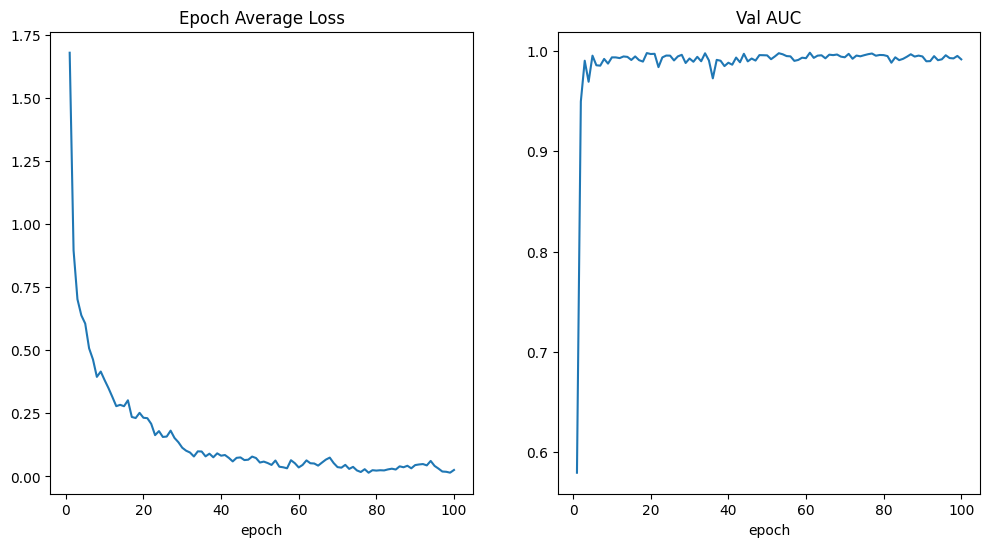

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [12]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6618    0.6618    0.6618        68
           2     0.7170    0.5507    0.6230        69
           3     0.4872    0.5846    0.5315        65
           4     0.5738    0.5385    0.5556        65
           5     1.0000    0.9697    0.9846        66
           6     0.9333    1.0000    0.9655        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9014    0.9275    0.9143        69
          10     0.9315    0.9855    0.9577        69

    accuracy                         0.8049       610
   macro avg     0.8356    0.8380    0.8352       610
weighted avg     0.8066    0.8049    0.8038       610



## Pretrained model

## Training cycle

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True, spatial_dims=3, n_input_channels=1, 
                 feed_forward=False, shortcut_type='A', bias_downsample=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [9]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [10]:
model.avgpool = nn.Sequential(
    model.avgpool,
    nn.Flatten(),
    nn.Linear(512, n_classes)
).to(device)

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=1.87]
                                                                                  

epoch 1 average loss: 2.3540
1


Epochs:   1%|          | 1/100 [00:26<44:12, 26.80s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6584 current accuracy: 0.2050 best AUC: 0.6584 at epoch: 1
----------
epoch 2/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=1.48]
                                                                                  

epoch 2 average loss: 1.5477
1


Epochs:   2%|▏         | 2/100 [00:52<42:53, 26.26s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9533 current accuracy: 0.4907 best AUC: 0.9533 at epoch: 2
----------
epoch 3/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=1.55]
                                                                                  

epoch 3 average loss: 1.1449
1


Epochs:   3%|▎         | 3/100 [01:18<42:21, 26.20s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9756 current accuracy: 0.6894 best AUC: 0.9756 at epoch: 3
----------
epoch 4/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.56it/s, train_loss=1.17]
                                                                                  

epoch 4 average loss: 0.9215
1


Epochs:   4%|▍         | 4/100 [01:44<41:38, 26.03s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9787 current accuracy: 0.7019 best AUC: 0.9787 at epoch: 4
----------
epoch 5/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=1.08]
                                                                                  

epoch 5 average loss: 0.8269


Epochs:   5%|▌         | 5/100 [02:09<40:30, 25.58s/it]

1
current epoch: 5 current AUC: 0.9722 current accuracy: 0.6770 best AUC: 0.9787 at epoch: 4
----------
epoch 6/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.62it/s, train_loss=0.62]
                                                                                  

epoch 6 average loss: 0.7520
1


Epochs:   6%|▌         | 6/100 [02:35<40:13, 25.67s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9810 current accuracy: 0.7453 best AUC: 0.9810 at epoch: 6
----------
epoch 7/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=0.917]
                                                                                   

epoch 7 average loss: 0.7203
1


Epochs:   7%|▋         | 7/100 [03:00<39:49, 25.70s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9822 current accuracy: 0.7453 best AUC: 0.9822 at epoch: 7
----------
epoch 8/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.60it/s, train_loss=0.87]
                                                                                  

epoch 8 average loss: 0.6966


Epochs:   8%|▊         | 8/100 [03:25<38:47, 25.30s/it]

1
current epoch: 8 current AUC: 0.9719 current accuracy: 0.6832 best AUC: 0.9822 at epoch: 7
----------
epoch 9/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.61it/s, train_loss=0.496]
                                                                                   

epoch 9 average loss: 0.6183
1


Epochs:   9%|▉         | 9/100 [03:51<38:40, 25.49s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9858 current accuracy: 0.8075 best AUC: 0.9858 at epoch: 9
----------
epoch 10/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.543]
                                                                                   

epoch 10 average loss: 0.5929
1


Epochs:  10%|█         | 10/100 [04:17<38:25, 25.61s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9871 current accuracy: 0.8137 best AUC: 0.9871 at epoch: 10
----------
epoch 11/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.538]
                                                                                   

epoch 11 average loss: 0.5573


Epochs:  11%|█         | 11/100 [04:42<37:39, 25.38s/it]

1
current epoch: 11 current AUC: 0.9764 current accuracy: 0.7019 best AUC: 0.9871 at epoch: 10
----------
epoch 12/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=2.65]
                                                                                  

epoch 12 average loss: 0.6510


Epochs:  12%|█▏        | 12/100 [05:06<36:56, 25.19s/it]

1
current epoch: 12 current AUC: 0.9858 current accuracy: 0.8075 best AUC: 0.9871 at epoch: 10
----------
epoch 13/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.412]
                                                                                   

epoch 13 average loss: 0.5262
1


Epochs:  13%|█▎        | 13/100 [05:33<37:04, 25.57s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9893 current accuracy: 0.8323 best AUC: 0.9893 at epoch: 13
----------
epoch 14/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=1.21]
                                                                                  

epoch 14 average loss: 0.5079
1


Epochs:  14%|█▍        | 14/100 [05:59<36:51, 25.71s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9904 current accuracy: 0.8571 best AUC: 0.9904 at epoch: 14
----------
epoch 15/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.337]
                                                                                   

epoch 15 average loss: 0.5348


Epochs:  15%|█▌        | 15/100 [06:23<35:57, 25.38s/it]

1
current epoch: 15 current AUC: 0.9895 current accuracy: 0.8509 best AUC: 0.9904 at epoch: 14
----------
epoch 16/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.56]
                                                                                  

epoch 16 average loss: 0.4402
1


Epochs:  16%|█▌        | 16/100 [06:50<35:51, 25.62s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9904 current accuracy: 0.8634 best AUC: 0.9904 at epoch: 16
----------
epoch 17/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.518]
                                                                                   

epoch 17 average loss: 0.3883
1


Epochs:  17%|█▋        | 17/100 [07:16<35:35, 25.73s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9945 current accuracy: 0.8447 best AUC: 0.9945 at epoch: 17
----------
epoch 18/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.419]
                                                                                   

epoch 18 average loss: 0.4184


Epochs:  18%|█▊        | 18/100 [07:40<34:48, 25.47s/it]

1
current epoch: 18 current AUC: 0.9897 current accuracy: 0.8571 best AUC: 0.9945 at epoch: 17
----------
epoch 19/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.248]
                                                                                   

epoch 19 average loss: 0.3901


Epochs:  19%|█▉        | 19/100 [08:06<34:13, 25.35s/it]

1
current epoch: 19 current AUC: 0.9928 current accuracy: 0.8820 best AUC: 0.9945 at epoch: 17
----------
epoch 20/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.924]
                                                                                   

epoch 20 average loss: 0.4336


Epochs:  20%|██        | 20/100 [08:30<33:36, 25.20s/it]

1
current epoch: 20 current AUC: 0.9938 current accuracy: 0.9006 best AUC: 0.9945 at epoch: 17
----------
epoch 21/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.453]
                                                                                   

epoch 21 average loss: 0.4012


Epochs:  21%|██        | 21/100 [08:55<32:57, 25.03s/it]

1
current epoch: 21 current AUC: 0.9928 current accuracy: 0.9006 best AUC: 0.9945 at epoch: 17
----------
epoch 22/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.512]
                                                                                   

epoch 22 average loss: 0.3886


Epochs:  22%|██▏       | 22/100 [09:20<32:30, 25.01s/it]

1
current epoch: 22 current AUC: 0.9920 current accuracy: 0.8820 best AUC: 0.9945 at epoch: 17
----------
epoch 23/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.592]
                                                                                   

epoch 23 average loss: 0.3864


Epochs:  23%|██▎       | 23/100 [09:45<32:02, 24.96s/it]

1
current epoch: 23 current AUC: 0.9912 current accuracy: 0.8882 best AUC: 0.9945 at epoch: 17
----------
epoch 24/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.365]
                                                                                   

epoch 24 average loss: 0.3510


Epochs:  24%|██▍       | 24/100 [10:10<31:46, 25.09s/it]

1
current epoch: 24 current AUC: 0.9889 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 17
----------
epoch 25/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.823]
                                                                                   

epoch 25 average loss: 0.3584


Epochs:  25%|██▌       | 25/100 [10:35<31:16, 25.02s/it]

1
current epoch: 25 current AUC: 0.9921 current accuracy: 0.8509 best AUC: 0.9945 at epoch: 17
----------
epoch 26/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.4]
                                                                                 

epoch 26 average loss: 0.3323


Epochs:  26%|██▌       | 26/100 [11:00<30:46, 24.95s/it]

1
current epoch: 26 current AUC: 0.9911 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 17
----------
epoch 27/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.422]
                                                                                   

epoch 27 average loss: 0.3282


Epochs:  27%|██▋       | 27/100 [11:25<30:17, 24.90s/it]

1
current epoch: 27 current AUC: 0.9902 current accuracy: 0.8820 best AUC: 0.9945 at epoch: 17
----------
epoch 28/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.498]
                                                                                   

epoch 28 average loss: 0.3196


Epochs:  28%|██▊       | 28/100 [11:50<29:55, 24.93s/it]

1
current epoch: 28 current AUC: 0.9912 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 17
----------
epoch 29/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.236]
                                                                                   

epoch 29 average loss: 0.3430
1


Epochs:  29%|██▉       | 29/100 [12:16<29:58, 25.34s/it]

saved new best metric model
current epoch: 29 current AUC: 0.9945 current accuracy: 0.8571 best AUC: 0.9945 at epoch: 29
----------
epoch 30/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.35]
                                                                                  

epoch 30 average loss: 0.3029


Epochs:  30%|███       | 30/100 [12:41<29:21, 25.16s/it]

1
current epoch: 30 current AUC: 0.9900 current accuracy: 0.8509 best AUC: 0.9945 at epoch: 29
----------
epoch 31/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.312]
                                                                                   

epoch 31 average loss: 0.3229


Epochs:  31%|███       | 31/100 [13:06<28:50, 25.08s/it]

1
current epoch: 31 current AUC: 0.9918 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 29
----------
epoch 32/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.256]
                                                                                   

epoch 32 average loss: 0.2470


Epochs:  32%|███▏      | 32/100 [13:30<28:20, 25.01s/it]

1
current epoch: 32 current AUC: 0.9898 current accuracy: 0.8634 best AUC: 0.9945 at epoch: 29
----------
epoch 33/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.24]
                                                                                  

epoch 33 average loss: 0.2751


Epochs:  33%|███▎      | 33/100 [13:55<27:53, 24.97s/it]

1
current epoch: 33 current AUC: 0.9923 current accuracy: 0.8634 best AUC: 0.9945 at epoch: 29
----------
epoch 34/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.55it/s, train_loss=0.72]
                                                                                  

epoch 34 average loss: 0.2915


Epochs:  34%|███▍      | 34/100 [14:20<27:20, 24.86s/it]

1
current epoch: 34 current AUC: 0.9919 current accuracy: 0.8571 best AUC: 0.9945 at epoch: 29
----------
epoch 35/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.187]
                                                                                   

epoch 35 average loss: 0.2843


Epochs:  35%|███▌      | 35/100 [14:45<26:53, 24.82s/it]

1
current epoch: 35 current AUC: 0.9936 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 29
----------
epoch 36/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.56it/s, train_loss=0.517]
                                                                                   

epoch 36 average loss: 0.2753


Epochs:  36%|███▌      | 36/100 [15:09<26:21, 24.72s/it]

1
current epoch: 36 current AUC: 0.9934 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 29
----------
epoch 37/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.227]
                                                                                   

epoch 37 average loss: 0.2631


Epochs:  37%|███▋      | 37/100 [15:34<25:58, 24.74s/it]

1
current epoch: 37 current AUC: 0.9943 current accuracy: 0.8944 best AUC: 0.9945 at epoch: 29
----------
epoch 38/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.62it/s, train_loss=0.73]
                                                                                  

epoch 38 average loss: 0.2905


Epochs:  38%|███▊      | 38/100 [15:59<25:32, 24.71s/it]

1
current epoch: 38 current AUC: 0.9939 current accuracy: 0.8696 best AUC: 0.9945 at epoch: 29
----------
epoch 39/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.715]
                                                                                   

epoch 39 average loss: 0.2906
1


Epochs:  39%|███▉      | 39/100 [16:24<25:28, 25.06s/it]

saved new best metric model
current epoch: 39 current AUC: 0.9963 current accuracy: 0.9006 best AUC: 0.9963 at epoch: 39
----------
epoch 40/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.389]
                                                                                   

epoch 40 average loss: 0.3255


Epochs:  40%|████      | 40/100 [16:49<25:00, 25.01s/it]

1
current epoch: 40 current AUC: 0.9953 current accuracy: 0.8882 best AUC: 0.9963 at epoch: 39
----------
epoch 41/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.619]
                                                                                   

epoch 41 average loss: 0.2842


Epochs:  41%|████      | 41/100 [17:14<24:34, 24.99s/it]

1
current epoch: 41 current AUC: 0.9941 current accuracy: 0.8323 best AUC: 0.9963 at epoch: 39
----------
epoch 42/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.285]
                                                                                   

epoch 42 average loss: 0.2694


Epochs:  42%|████▏     | 42/100 [17:39<24:07, 24.95s/it]

1
current epoch: 42 current AUC: 0.9946 current accuracy: 0.9130 best AUC: 0.9963 at epoch: 39
----------
epoch 43/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.272]
                                                                                   

epoch 43 average loss: 0.2336


Epochs:  43%|████▎     | 43/100 [18:04<23:40, 24.92s/it]

1
current epoch: 43 current AUC: 0.9925 current accuracy: 0.8696 best AUC: 0.9963 at epoch: 39
----------
epoch 44/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.25]
                                                                                  

epoch 44 average loss: 0.2411


Epochs:  44%|████▍     | 44/100 [18:29<23:16, 24.94s/it]

1
current epoch: 44 current AUC: 0.9937 current accuracy: 0.9130 best AUC: 0.9963 at epoch: 39
----------
epoch 45/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.533]
                                                                                   

epoch 45 average loss: 0.2138


Epochs:  45%|████▌     | 45/100 [18:54<22:52, 24.95s/it]

1
current epoch: 45 current AUC: 0.9937 current accuracy: 0.9068 best AUC: 0.9963 at epoch: 39
----------
epoch 46/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.661]
                                                                                   

epoch 46 average loss: 0.2582


Epochs:  46%|████▌     | 46/100 [19:19<22:24, 24.91s/it]

1
current epoch: 46 current AUC: 0.9936 current accuracy: 0.8696 best AUC: 0.9963 at epoch: 39
----------
epoch 47/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.446]
                                                                                   

epoch 47 average loss: 0.2390
1


Epochs:  47%|████▋     | 47/100 [19:45<22:19, 25.27s/it]

saved new best metric model
current epoch: 47 current AUC: 0.9972 current accuracy: 0.9130 best AUC: 0.9972 at epoch: 47
----------
epoch 48/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.467]
                                                                                   

epoch 48 average loss: 0.2454
1


Epochs:  48%|████▊     | 48/100 [20:11<22:06, 25.51s/it]

saved new best metric model
current epoch: 48 current AUC: 0.9987 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 48
----------
epoch 49/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.74]
                                                                                  

epoch 49 average loss: 0.2229


Epochs:  49%|████▉     | 49/100 [20:36<21:31, 25.33s/it]

1
current epoch: 49 current AUC: 0.9958 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 50/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0773]
                                                                                    

epoch 50 average loss: 0.2165


Epochs:  50%|█████     | 50/100 [21:01<20:57, 25.14s/it]

1
current epoch: 50 current AUC: 0.9941 current accuracy: 0.8571 best AUC: 0.9987 at epoch: 48
----------
epoch 51/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.372]
                                                                                   

epoch 51 average loss: 0.2253


Epochs:  51%|█████     | 51/100 [21:25<20:28, 25.06s/it]

1
current epoch: 51 current AUC: 0.9866 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 52/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.531]
                                                                                   

epoch 52 average loss: 0.2252


Epochs:  52%|█████▏    | 52/100 [21:50<20:02, 25.06s/it]

1
current epoch: 52 current AUC: 0.9880 current accuracy: 0.8696 best AUC: 0.9987 at epoch: 48
----------
epoch 53/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=1.04]
                                                                                  

epoch 53 average loss: 0.2357


Epochs:  53%|█████▎    | 53/100 [22:15<19:34, 24.98s/it]

1
current epoch: 53 current AUC: 0.9929 current accuracy: 0.8634 best AUC: 0.9987 at epoch: 48
----------
epoch 54/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.59it/s, train_loss=0.158]
                                                                                   

epoch 54 average loss: 0.2119


Epochs:  54%|█████▍    | 54/100 [22:40<19:03, 24.85s/it]

1
current epoch: 54 current AUC: 0.9937 current accuracy: 0.8882 best AUC: 0.9987 at epoch: 48
----------
epoch 55/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.59it/s, train_loss=0.3]
                                                                                 

epoch 55 average loss: 0.1948


Epochs:  55%|█████▌    | 55/100 [23:04<18:33, 24.75s/it]

1
current epoch: 55 current AUC: 0.9953 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 48
----------
epoch 56/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.321]
                                                                                   

epoch 56 average loss: 0.1933


Epochs:  56%|█████▌    | 56/100 [23:29<18:10, 24.78s/it]

1
current epoch: 56 current AUC: 0.9956 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 48
----------
epoch 57/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.52it/s, train_loss=0.286]
                                                                                   

epoch 57 average loss: 0.1982


Epochs:  57%|█████▋    | 57/100 [23:54<17:43, 24.72s/it]

1
current epoch: 57 current AUC: 0.9917 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 58/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.139]
                                                                                   

epoch 61 average loss: 0.1668


Epochs:  61%|██████    | 61/100 [25:33<16:05, 24.76s/it]

1
current epoch: 61 current AUC: 0.9953 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 62/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0986]
                                                                                    

epoch 62 average loss: 0.1891


Epochs:  62%|██████▏   | 62/100 [25:58<15:40, 24.76s/it]

1
current epoch: 62 current AUC: 0.9964 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 48
----------
epoch 63/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.3]
                                                                                 

epoch 63 average loss: 0.1626


Epochs:  63%|██████▎   | 63/100 [26:23<15:17, 24.80s/it]

1
current epoch: 63 current AUC: 0.9910 current accuracy: 0.8696 best AUC: 0.9987 at epoch: 48
----------
epoch 64/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.398]
                                                                                   

epoch 64 average loss: 0.1981


Epochs:  64%|██████▍   | 64/100 [26:47<14:53, 24.83s/it]

1
current epoch: 64 current AUC: 0.9952 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 48
----------
epoch 65/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.502]
                                                                                   

epoch 65 average loss: 0.1808


Epochs:  65%|██████▌   | 65/100 [27:12<14:30, 24.86s/it]

1
current epoch: 65 current AUC: 0.9934 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 48
----------
epoch 66/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.425]
                                                                                   

epoch 66 average loss: 0.1714


Epochs:  66%|██████▌   | 66/100 [27:37<14:03, 24.80s/it]

1
current epoch: 66 current AUC: 0.9954 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 48
----------
epoch 67/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.153]
                                                                                   

epoch 67 average loss: 0.1837


Epochs:  67%|██████▋   | 67/100 [28:02<13:37, 24.78s/it]

1
current epoch: 67 current AUC: 0.9956 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 48
----------
epoch 68/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.284]
                                                                                   

epoch 68 average loss: 0.1695


Epochs:  68%|██████▊   | 68/100 [28:27<13:15, 24.85s/it]

1
current epoch: 68 current AUC: 0.9932 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 48
----------
epoch 69/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.278]
                                                                                   

epoch 69 average loss: 0.1625


Epochs:  69%|██████▉   | 69/100 [28:52<12:49, 24.84s/it]

1
current epoch: 69 current AUC: 0.9922 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 70/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.24]
                                                                                  

epoch 70 average loss: 0.1910


Epochs:  70%|███████   | 70/100 [29:16<12:25, 24.86s/it]

1
current epoch: 70 current AUC: 0.9967 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 48
----------
epoch 71/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.0894]
                                                                                    

epoch 71 average loss: 0.1458


Epochs:  71%|███████   | 71/100 [29:42<12:02, 24.92s/it]

1
current epoch: 71 current AUC: 0.9928 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 72/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.116]
                                                                                   

epoch 72 average loss: 0.1425


Epochs:  72%|███████▏  | 72/100 [30:06<11:35, 24.86s/it]

1
current epoch: 72 current AUC: 0.9958 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 48
----------
epoch 73/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.124]
                                                                                   

epoch 73 average loss: 0.1617


Epochs:  73%|███████▎  | 73/100 [30:31<11:10, 24.84s/it]

1
current epoch: 73 current AUC: 0.9956 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 74/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0982]
                                                                                    

epoch 74 average loss: 0.1490


Epochs:  74%|███████▍  | 74/100 [30:56<10:46, 24.86s/it]

1
current epoch: 74 current AUC: 0.9947 current accuracy: 0.9130 best AUC: 0.9987 at epoch: 48
----------
epoch 75/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.805]
                                                                                   

epoch 79 average loss: 0.1856


Epochs:  79%|███████▉  | 79/100 [33:01<08:42, 24.89s/it]

1
current epoch: 79 current AUC: 0.9947 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 48
----------
epoch 80/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.62it/s, train_loss=0.139]
                                                                                   

epoch 80 average loss: 0.1609


Epochs:  80%|████████  | 80/100 [33:25<08:17, 24.89s/it]

1
current epoch: 80 current AUC: 0.9943 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 48
----------
epoch 81/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.118]
                                                                                   

epoch 81 average loss: 0.1347


Epochs:  81%|████████  | 81/100 [33:51<07:54, 24.96s/it]

1
current epoch: 81 current AUC: 0.9981 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 48
----------
epoch 82/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.618]
                                                                                   

epoch 82 average loss: 0.1508


Epochs:  82%|████████▏ | 82/100 [34:16<07:30, 25.02s/it]

1
current epoch: 82 current AUC: 0.9946 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 83/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.0569]
                                                                                    

epoch 83 average loss: 0.1402


Epochs:  83%|████████▎ | 83/100 [34:41<07:04, 24.96s/it]

1
current epoch: 83 current AUC: 0.9950 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 48
----------
epoch 84/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.0631]
                                                                                    

epoch 84 average loss: 0.1195


Epochs:  84%|████████▍ | 84/100 [35:06<06:39, 24.98s/it]

1
current epoch: 84 current AUC: 0.9973 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 48
----------
epoch 85/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.282]
                                                                                   

epoch 85 average loss: 0.1256


Epochs:  85%|████████▌ | 85/100 [35:30<06:14, 24.94s/it]

1
current epoch: 85 current AUC: 0.9920 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 48
----------
epoch 86/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0188]
                                                                                    

epoch 86 average loss: 0.1152


Epochs:  86%|████████▌ | 86/100 [35:55<05:49, 24.94s/it]

1
current epoch: 86 current AUC: 0.9914 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 87/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.0359]
                                                                                    

epoch 87 average loss: 0.1407


Epochs:  87%|████████▋ | 87/100 [36:20<05:24, 25.00s/it]

1
current epoch: 87 current AUC: 0.9956 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 88/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.209]
                                                                                   

epoch 88 average loss: 0.1017


Epochs:  88%|████████▊ | 88/100 [36:46<05:00, 25.00s/it]

1
current epoch: 88 current AUC: 0.9962 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 89/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.237]
                                                                                   

epoch 89 average loss: 0.1364


Epochs:  89%|████████▉ | 89/100 [37:11<04:35, 25.01s/it]

1
current epoch: 89 current AUC: 0.9929 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 48
----------
epoch 90/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.766]
                                                                                   

epoch 90 average loss: 0.1470


Epochs:  90%|█████████ | 90/100 [37:36<04:10, 25.01s/it]

1
current epoch: 90 current AUC: 0.9899 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 48
----------
epoch 91/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.62it/s, train_loss=0.246]
                                                                                   

epoch 91 average loss: 0.1366


Epochs:  91%|█████████ | 91/100 [38:00<03:43, 24.82s/it]

1
current epoch: 91 current AUC: 0.9958 current accuracy: 0.9255 best AUC: 0.9987 at epoch: 48
----------
epoch 92/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.496]
                                                                                   

epoch 92 average loss: 0.1540


Epochs:  92%|█████████▏| 92/100 [38:25<03:19, 24.88s/it]

1
current epoch: 92 current AUC: 0.9949 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 48
----------
epoch 93/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.50it/s, train_loss=0.0123]
                                                                                    

epoch 93 average loss: 0.1403


Epochs:  93%|█████████▎| 93/100 [38:50<02:54, 24.93s/it]

1
current epoch: 93 current AUC: 0.9942 current accuracy: 0.8696 best AUC: 0.9987 at epoch: 48
----------
epoch 94/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0691]
                                                                                    

epoch 94 average loss: 0.1248


Epochs:  94%|█████████▍| 94/100 [39:15<02:29, 24.93s/it]

1
current epoch: 94 current AUC: 0.9967 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 48
----------
epoch 95/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.104]
                                                                                   

epoch 95 average loss: 0.1039


Epochs:  95%|█████████▌| 95/100 [39:40<02:04, 24.91s/it]

1
current epoch: 95 current AUC: 0.9920 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 48
----------
epoch 96/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0193]
                                                                                    

epoch 96 average loss: 0.0993


Epochs:  96%|█████████▌| 96/100 [40:05<01:39, 24.92s/it]

1
current epoch: 96 current AUC: 0.9967 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 48
----------
epoch 97/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.0985]
                                                                                    

epoch 97 average loss: 0.0984


Epochs:  97%|█████████▋| 97/100 [40:30<01:14, 24.95s/it]

1
current epoch: 97 current AUC: 0.9939 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 48
----------
epoch 98/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.0744]
                                                                                    

epoch 98 average loss: 0.0984


Epochs:  98%|█████████▊| 98/100 [40:55<00:49, 24.93s/it]

1
current epoch: 98 current AUC: 0.9872 current accuracy: 0.8385 best AUC: 0.9987 at epoch: 48
----------
epoch 99/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.266]
                                                                                   

epoch 99 average loss: 0.1042


Epochs:  99%|█████████▉| 99/100 [41:19<00:24, 24.86s/it]

1
current epoch: 99 current AUC: 0.9937 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 48
----------
epoch 100/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.50it/s, train_loss=0.0305]
                                                                                    

epoch 100 average loss: 0.0928


Epochs: 100%|██████████| 100/100 [41:44<00:00, 25.05s/it]

1
current epoch: 100 current AUC: 0.9949 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 48
train completed, best_metric: 0.9987 at epoch: 48


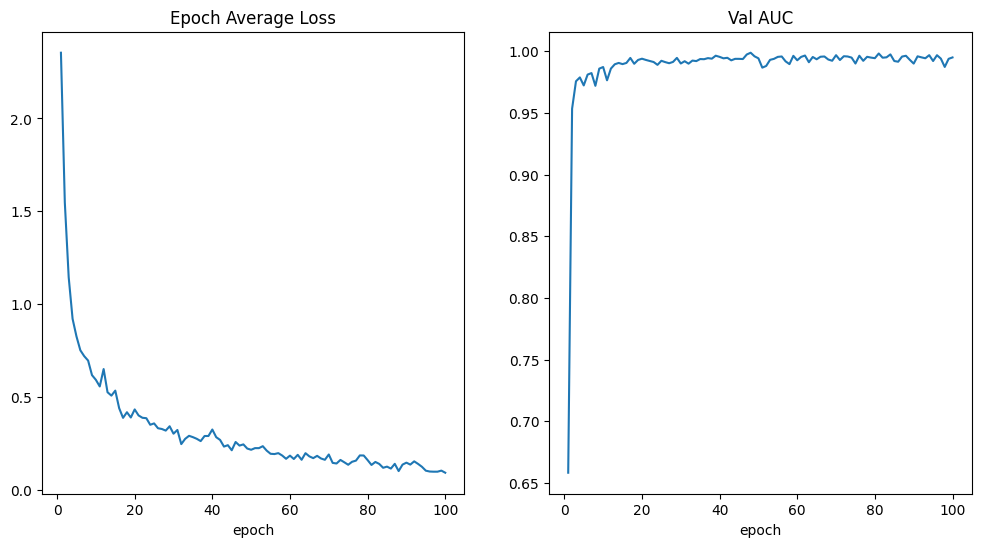

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [13]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [14]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.6719    0.6324    0.6515        68
           2     0.6301    0.6667    0.6479        69
           3     0.5357    0.4615    0.4959        65
           4     0.5571    0.6000    0.5778        65
           5     0.8841    0.9242    0.9037        66
           6     1.0000    0.8214    0.9020        28
           7     0.9130    1.0000    0.9545        21
           8     1.0000    1.0000    1.0000        21
           9     0.9254    0.8986    0.9118        69
          10     0.8904    0.9420    0.9155        69

    accuracy                         0.7869       610
   macro avg     0.8163    0.8133    0.8133       610
weighted avg     0.7854    0.7869    0.7850       610

